#Momento de Retroalimentación: Módulo 2 
##Implementación de un modelo de deep learning

Implementación de red CNN para reto de clasificación de imagenes de Intel sobre distintos paisajes alrededor del mundo distribuidos en 6 categorías:


1.   Edificios (buildings)
2.   Bosque (forest)
3. Glaciar (glacier)
4. Montaña (mountain)
5. Mar (sea)
6. Calle (street)

Disponible en Kaggle: https://www.kaggle.com/datasets/puneet6060/intel-image-classification





In [2]:
#Librerias
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [3]:
# Acceso a kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianacaibevalle","key":"fcc76552f62ba8d11489c4c6287dfc16"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Validación de kaggle 
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           3554        114  1.0              
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          20027        553  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           2555         65  1.0              
fuarresvij/gdp-growth-around-the-globe                      

In [5]:
#Descarga de set de datos
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 336M/346M [00:01<00:00, 273MB/s]
100% 346M/346M [00:01<00:00, 273MB/s]


In [6]:
!unzip -qq intel-image-classification.zip

Las imagenes estan convenientemete separados en 3 folders:
1. Entrenamiento - train (14000 imagenes aprox.)
2. Prueba - test (3000 imagenes aprox.)
3. Predicción - prediction (7000 imagenes aprox.)

Y en general las dimensiones de todas son 150x150x3

In [7]:
train_dir = 'seg_train/seg_train/'
validation_dir = 'seg_test/seg_test/'
prediction_dir = 'seg_pred/seg_pred/'

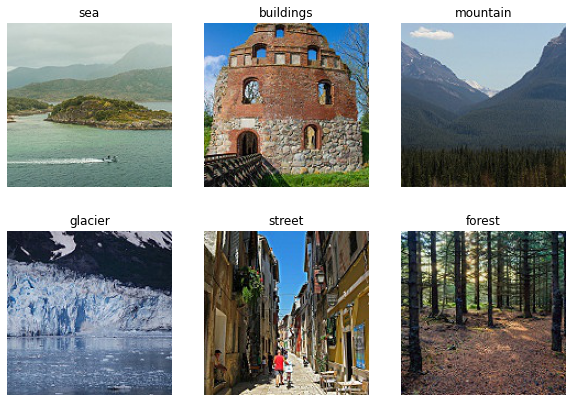

In [8]:
# Imagenes muestra de cada categoría 
plt.figure(figsize=(10, 7))
for i, folder in enumerate(os.listdir(train_dir)):
    ax = plt.subplot(2, 3, i + 1)
    img = plt.imread(train_dir+folder +'/'+ os.listdir(train_dir+folder)[0])
    plt.imshow(img)
    plt.title(folder)
    plt.axis("off")

Haremos un modelo inicial simple y sin previo preprocesamiento de las imágenes solo para ver el comportamiento de la clasificación así, con la hipotésis de que no se obtendrán los mejores resultados posibles. 



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Train dataset
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_dataset  = train_data_gen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed=21)

# Validation dataset
val_data_gen  = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_dataset = val_data_gen.flow_from_directory(validation_dir,
                                                      target_size=(150, 150),
                                                      color_mode='rgb',
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      shuffle=False,
                                                      seed=21)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
from tensorflow import keras 
from keras import layers

# Modelo inicial 
model = keras.Sequential([keras.Input(shape=(150, 150, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [12]:
#Optimizador y métricas
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = acc)

In [13]:
# Guardar mejor modelo y detener el modelo en base a la pérdida en validación
mc= keras.callbacks.ModelCheckpoint(
        filepath="weights",
        save_best_only=True,
        monitor="val_loss")
es = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

with tf.device('/device:GPU:0'):
  #Entrenamiento
  history = model.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=[mc,es])

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.2316 - categorical_accuracy: 0.5157

439/439 [==============================] - 35s 59ms/step - loss: 1.2316 - categorical_accuracy: 0.5157 - val_loss: 1.1705 - val_categorical_accuracy: 0.5443
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.0083 - categorical_accuracy: 0.6006

439/439 [==============================] - 25s 57ms/step - loss: 1.0083 - categorical_accuracy: 0.6006 - val_loss: 0.9732 - val_categorical_accuracy: 0.6320
Epoch 3/30
438/439 [============================>.] - ETA: 0s - loss: 0.9067 - categorical_accuracy: 0.6496

439/439 [==============================] - 25s 57ms/step - loss: 0.9070 - categorical_accuracy: 0.6495 - val_loss: 0.9212 - val_categorical_accuracy: 0.6517
Epoch 4/30
438/439 [============================>.] - ETA: 0s - loss: 0.8211 - categorical_accuracy: 0.6855

439/439 [==============================] - 26s 59ms/step - loss: 0.8210 - categorical_accuracy: 0.6857 - val_loss: 0.8210 - val_categorical_accuracy: 0.6813
Epoch 5/30
438/439 [============================>.] - ETA: 0s - loss: 0.7616 - categorical_accuracy: 0.7105

439/439 [==============================] - 25s 57ms/step - loss: 0.7619 - categorical_accuracy: 0.7104 - val_loss: 0.8077 - val_categorical_accuracy: 0.6813
Epoch 6/30
439/439 [==============================] - 24s 55ms/step - loss: 0.7351 - categorical_accuracy: 0.7159 - val_loss: 0.8248 - val_categorical_accuracy: 0.6777
Epoch 7/30
439/439 [==============================] - ETA: 0s - loss: 0.6933 - categorical_accuracy: 0.7364

439/439 [==============================] - 25s 57ms/step - loss: 0.6933 - categorical_accuracy: 0.7364 - val_loss: 0.7880 - val_categorical_accuracy: 0.7053
Epoch 8/30
438/439 [============================>.] - ETA: 0s - loss: 0.6596 - categorical_accuracy: 0.7492

439/439 [==============================] - 25s 56ms/step - loss: 0.6602 - categorical_accuracy: 0.7490 - val_loss: 0.7743 - val_categorical_accuracy: 0.7103
Epoch 9/30
438/439 [============================>.] - ETA: 0s - loss: 0.6297 - categorical_accuracy: 0.7609

439/439 [==============================] - 25s 56ms/step - loss: 0.6294 - categorical_accuracy: 0.7611 - val_loss: 0.6988 - val_categorical_accuracy: 0.7340
Epoch 10/30
439/439 [==============================] - 25s 56ms/step - loss: 0.5961 - categorical_accuracy: 0.7753 - val_loss: 0.7249 - val_categorical_accuracy: 0.7323
Epoch 11/30
438/439 [============================>.] - ETA: 0s - loss: 0.5564 - categorical_accuracy: 0.7946

439/439 [==============================] - 25s 57ms/step - loss: 0.5572 - categorical_accuracy: 0.7945 - val_loss: 0.6757 - val_categorical_accuracy: 0.7547
Epoch 12/30
439/439 [==============================] - 24s 54ms/step - loss: 0.5201 - categorical_accuracy: 0.8055 - val_loss: 0.7534 - val_categorical_accuracy: 0.7370
Epoch 13/30
439/439 [==============================] - 24s 54ms/step - loss: 0.4946 - categorical_accuracy: 0.8178 - val_loss: 0.7257 - val_categorical_accuracy: 0.7447
Epoch 14/30
439/439 [==============================] - 24s 54ms/step - loss: 0.4513 - categorical_accuracy: 0.8335 - val_loss: 0.7517 - val_categorical_accuracy: 0.7310
Epoch 15/30
439/439 [==============================] - 24s 54ms/step - loss: 0.4232 - categorical_accuracy: 0.8465 - val_loss: 0.7295 - val_categorical_accuracy: 0.7370
Epoch 16/30
439/439 [==============================] - 24s 55ms/step - loss: 0.3758 - categorical_accuracy: 0.8664 - val_loss: 0.7667 - val_categorical_accuracy: 0.738

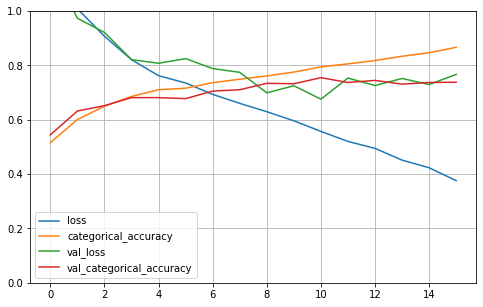

In [15]:
#Gráfica de linea de aprendizaje 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show(); 

Como podemos observar en la gráfica empieza a haber un overfitt que causa una gran separación entre la péridad del conjunto de entrenamiento y el de validación. También el valor de la exactitud de predición con respecto de cada conjunto se distancia y en la validación podemos ver como no mejora mucho del 75%. 

In [16]:
from tensorflow.keras.preprocessing import image

#Función para clasificar una imagen y regresar su etiqueta de clase predecida
def classify(img_path, model):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    #Predicción
    prediction = model.predict(img_preprocessed)
    prediction = np.argmax(prediction, axis=1)
    #Etiquetas
    labels = [k for k,v in train_dataset.class_indices.items()]
    label_pred = [labels[k] for k in prediction]
    return label_pred[0]   

1/1 [==============================] - 0s 25ms/step


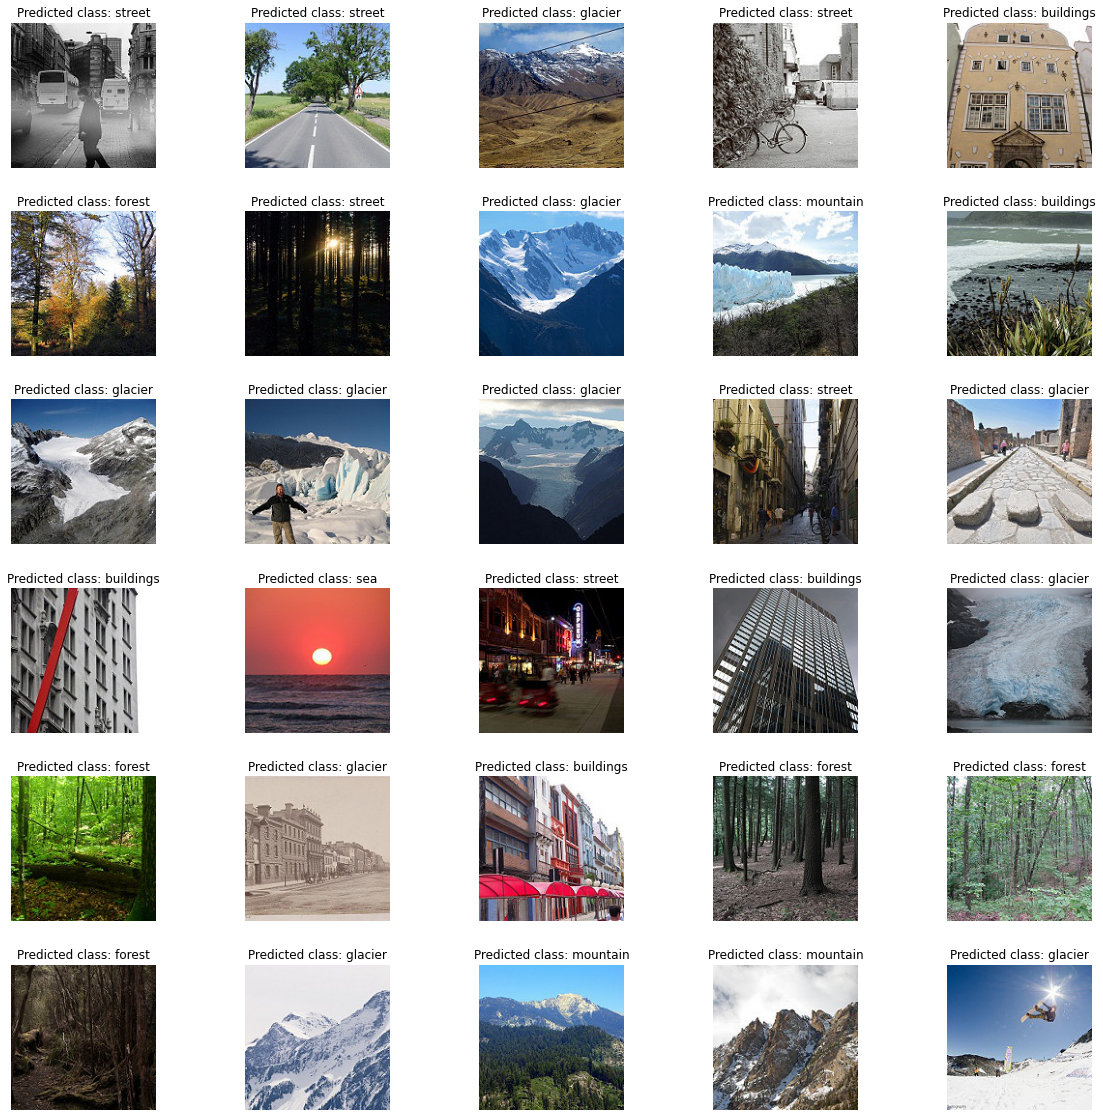

In [18]:
# 30 predicciones del conjunto de imagenes de predicción
plt.figure(figsize = (20 , 20))
for i in range(30):
    plt.subplot(6 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    image_path = prediction_dir + random.choice(os.listdir(prediction_dir))
    prediction = classify(image_path,model)
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted class: {prediction}')
    plt.axis("off")

Realizamos algunas predicciones con este modelo y de 30 imagenes podemos ver que clasificó correctamente 25/30, por lo tanto tuvo 5/30 erróneas. 
Esto significa un error del 16.66% del total de predicciones.  

Haremos algunos cambios al modelo para ver si mejora el desempeño añadiendo algunas partes referentes a "data augmentation" , pero sin cambiar la arquitectura original de la red

In [19]:
# Modelo inicial
model = keras.Sequential([keras.Input(shape=(150, 150, 3)),
                          layers.RandomFlip("horizontal"), #DA
                          layers.RandomRotation(0.1), #DA
                          layers.RandomZoom(0.2), #DA
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                  

In [20]:
# Optimizador y métricas
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = acc)

In [21]:
# Guardar mejor modelo y detener el modelo en base a la pérdida en validación
mc= keras.callbacks.ModelCheckpoint(
        filepath="weights",
        save_best_only=True,
        monitor="val_loss")
es = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

with tf.device('/device:GPU:0'):
  #Entrenamiento
  history2 = model.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=[mc,es])

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.3879 - categorical_accuracy: 0.4366

439/439 [==============================] - 42s 93ms/step - loss: 1.3879 - categorical_accuracy: 0.4366 - val_loss: 1.2808 - val_categorical_accuracy: 0.5150
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.1120 - categorical_accuracy: 0.5582

439/439 [==============================] - 38s 87ms/step - loss: 1.1120 - categorical_accuracy: 0.5582 - val_loss: 0.9642 - val_categorical_accuracy: 0.6070
Epoch 3/30
438/439 [============================>.] - ETA: 0s - loss: 0.9950 - categorical_accuracy: 0.6176

439/439 [==============================] - 38s 87ms/step - loss: 0.9942 - categorical_accuracy: 0.6179 - val_loss: 0.9152 - val_categorical_accuracy: 0.6500
Epoch 4/30
438/439 [============================>.] - ETA: 0s - loss: 0.9363 - categorical_accuracy: 0.6349

439/439 [==============================] - 40s 90ms/step - loss: 0.9369 - categorical_accuracy: 0.6349 - val_loss: 0.8445 - val_categorical_accuracy: 0.6773
Epoch 5/30
439/439 [==============================] - ETA: 0s - loss: 0.9003 - categorical_accuracy: 0.6518

439/439 [==============================] - 39s 89ms/step - loss: 0.9003 - categorical_accuracy: 0.6518 - val_loss: 0.8141 - val_categorical_accuracy: 0.6983
Epoch 6/30
439/439 [==============================] - 37s 84ms/step - loss: 0.8687 - categorical_accuracy: 0.6670 - val_loss: 0.8219 - val_categorical_accuracy: 0.6947
Epoch 7/30
438/439 [============================>.] - ETA: 0s - loss: 0.8458 - categorical_accuracy: 0.6757

439/439 [==============================] - 39s 88ms/step - loss: 0.8459 - categorical_accuracy: 0.6756 - val_loss: 0.7943 - val_categorical_accuracy: 0.7043
Epoch 8/30
438/439 [============================>.] - ETA: 0s - loss: 0.8163 - categorical_accuracy: 0.6887

439/439 [==============================] - 40s 91ms/step - loss: 0.8167 - categorical_accuracy: 0.6885 - val_loss: 0.7555 - val_categorical_accuracy: 0.7173
Epoch 9/30
439/439 [==============================] - 37s 83ms/step - loss: 0.7925 - categorical_accuracy: 0.7031 - val_loss: 0.8260 - val_categorical_accuracy: 0.6940
Epoch 10/30
438/439 [============================>.] - ETA: 0s - loss: 0.7643 - categorical_accuracy: 0.7179

439/439 [==============================] - 38s 87ms/step - loss: 0.7641 - categorical_accuracy: 0.7179 - val_loss: 0.6935 - val_categorical_accuracy: 0.7467
Epoch 11/30
439/439 [==============================] - 37s 84ms/step - loss: 0.7406 - categorical_accuracy: 0.7246 - val_loss: 0.7780 - val_categorical_accuracy: 0.7210
Epoch 12/30
438/439 [============================>.] - ETA: 0s - loss: 0.7206 - categorical_accuracy: 0.7349

439/439 [==============================] - 40s 90ms/step - loss: 0.7207 - categorical_accuracy: 0.7350 - val_loss: 0.6815 - val_categorical_accuracy: 0.7433
Epoch 13/30
439/439 [==============================] - ETA: 0s - loss: 0.6947 - categorical_accuracy: 0.7456

439/439 [==============================] - 39s 88ms/step - loss: 0.6947 - categorical_accuracy: 0.7456 - val_loss: 0.6470 - val_categorical_accuracy: 0.7600
Epoch 14/30
439/439 [==============================] - 37s 83ms/step - loss: 0.6823 - categorical_accuracy: 0.7498 - val_loss: 0.6630 - val_categorical_accuracy: 0.7587
Epoch 15/30
439/439 [==============================] - ETA: 0s - loss: 0.6561 - categorical_accuracy: 0.7611

439/439 [==============================] - 39s 90ms/step - loss: 0.6561 - categorical_accuracy: 0.7611 - val_loss: 0.6308 - val_categorical_accuracy: 0.7743
Epoch 16/30
438/439 [============================>.] - ETA: 0s - loss: 0.6525 - categorical_accuracy: 0.7639

439/439 [==============================] - 38s 87ms/step - loss: 0.6523 - categorical_accuracy: 0.7641 - val_loss: 0.5818 - val_categorical_accuracy: 0.7937
Epoch 17/30
439/439 [==============================] - ETA: 0s - loss: 0.6382 - categorical_accuracy: 0.7684

439/439 [==============================] - 38s 87ms/step - loss: 0.6382 - categorical_accuracy: 0.7684 - val_loss: 0.5783 - val_categorical_accuracy: 0.7853
Epoch 18/30
439/439 [==============================] - 36s 81ms/step - loss: 0.6211 - categorical_accuracy: 0.7764 - val_loss: 0.6481 - val_categorical_accuracy: 0.7573
Epoch 19/30
439/439 [==============================] - 37s 85ms/step - loss: 0.5994 - categorical_accuracy: 0.7815 - val_loss: 0.6191 - val_categorical_accuracy: 0.7743
Epoch 20/30
439/439 [==============================] - 36s 81ms/step - loss: 0.5821 - categorical_accuracy: 0.7951 - val_loss: 0.5813 - val_categorical_accuracy: 0.7810
Epoch 21/30
439/439 [==============================] - 36s 81ms/step - loss: 0.5680 - categorical_accuracy: 0.7978 - val_loss: 0.6650 - val_categorical_accuracy: 0.7577
Epoch 22/30
438/439 [============================>.] - ETA: 0s - loss: 0.5725 - categorical_accuracy: 0.7915

439/439 [==============================] - 38s 86ms/step - loss: 0.5728 - categorical_accuracy: 0.7913 - val_loss: 0.5599 - val_categorical_accuracy: 0.8007
Epoch 23/30
439/439 [==============================] - 37s 84ms/step - loss: 0.5565 - categorical_accuracy: 0.7993 - val_loss: 0.5970 - val_categorical_accuracy: 0.7903
Epoch 24/30
439/439 [==============================] - 36s 83ms/step - loss: 0.5425 - categorical_accuracy: 0.8075 - val_loss: 0.5638 - val_categorical_accuracy: 0.7953
Epoch 25/30
439/439 [==============================] - 36s 82ms/step - loss: 0.5286 - categorical_accuracy: 0.8089 - val_loss: 0.5646 - val_categorical_accuracy: 0.7963
Epoch 26/30
438/439 [============================>.] - ETA: 0s - loss: 0.5273 - categorical_accuracy: 0.8104

439/439 [==============================] - 38s 87ms/step - loss: 0.5274 - categorical_accuracy: 0.8106 - val_loss: 0.5290 - val_categorical_accuracy: 0.8170
Epoch 27/30
439/439 [==============================] - 41s 93ms/step - loss: 0.5151 - categorical_accuracy: 0.8179 - val_loss: 0.5402 - val_categorical_accuracy: 0.8057
Epoch 28/30
439/439 [==============================] - 37s 83ms/step - loss: 0.5097 - categorical_accuracy: 0.8146 - val_loss: 0.5463 - val_categorical_accuracy: 0.7997
Epoch 29/30
439/439 [==============================] - 39s 88ms/step - loss: 0.4953 - categorical_accuracy: 0.8219 - val_loss: 0.5619 - val_categorical_accuracy: 0.8057
Epoch 30/30
439/439 [==============================] - 37s 84ms/step - loss: 0.4952 - categorical_accuracy: 0.8250 - val_loss: 0.5496 - val_categorical_accuracy: 0.8057


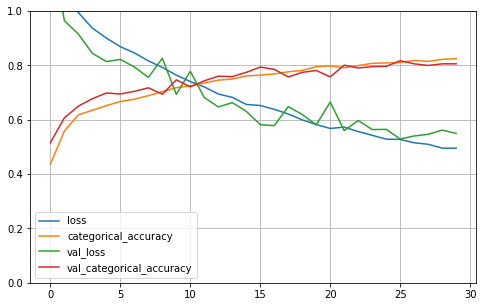

In [22]:
#Gráfica de linea de aprendizaje 
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show(); 

Podemos ver que el entrenamiento fue más largo que la versión previa, acompletando las 30 épocas, sin embargo la pérdida siguen sin tener los mejores resultados pero el comportamiento del aprendizaje en general es mejor. El acurracy logra llegar al 80% y no hay un overfitt tan elevado. 

1/1 [==============================] - 0s 15ms/step


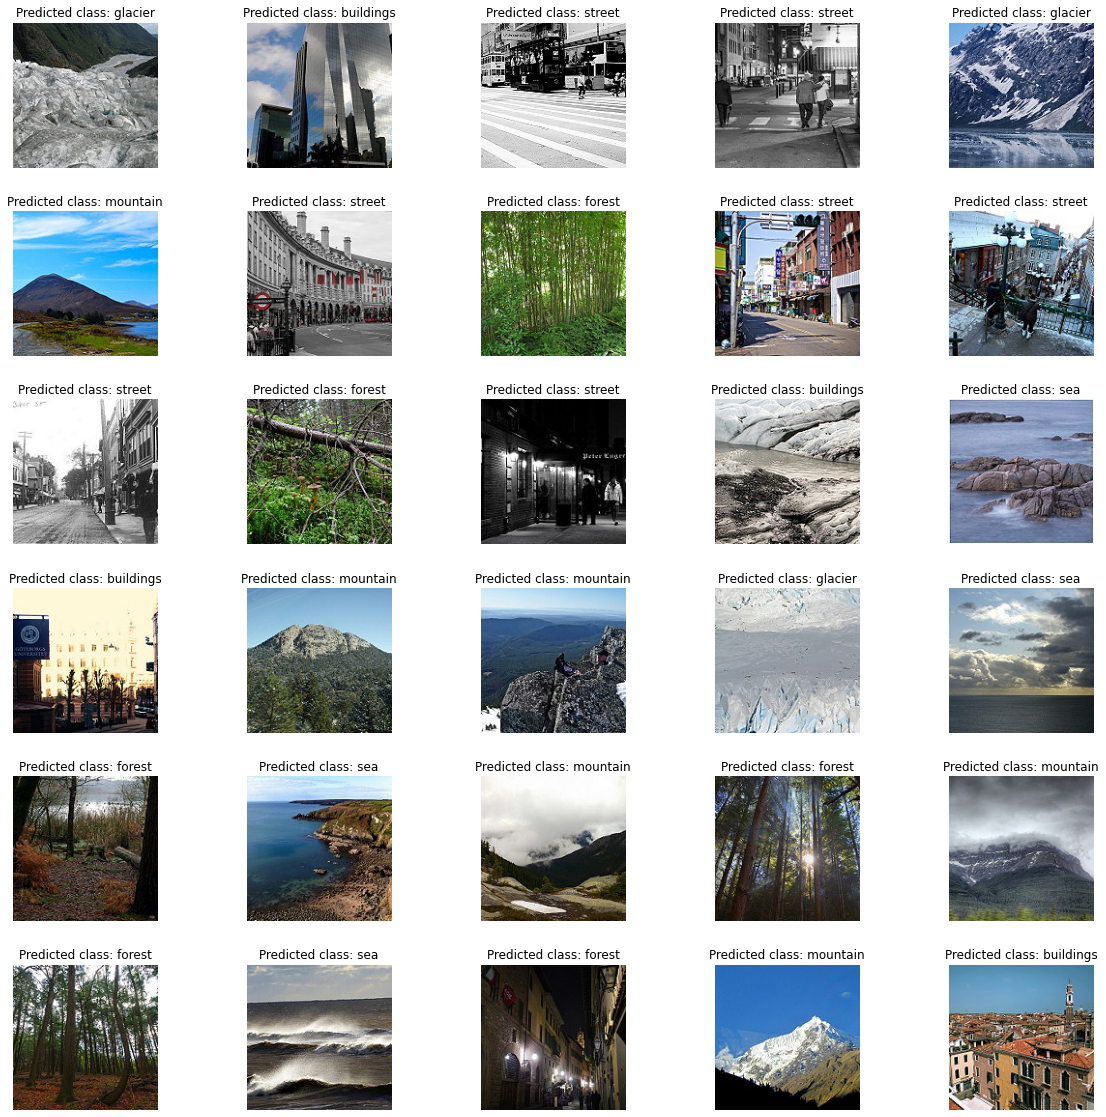

In [23]:
# 30 predicciones del conjunto de imagenes de predicción
plt.figure(figsize = (20 , 20))
for i in range(30):
    plt.subplot(6 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    image_path = prediction_dir + random.choice(os.listdir(prediction_dir))
    prediction = classify(image_path,model)
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted class: {prediction}')
    plt.axis("off")

En este conjunto de predicciones podemos apreciar como ha mejorado el desempeño clasificando correctamente 28/30 , equivocandose en solo 2/30, y aunque es una buena cantidad, se puede notar que no ha logrado terminar la distinción de algunos elementos al confundir un glaciar con edificos y un bosque con una calle iluminada.

Con el objetivo de mejorar aún más el modelo aplicaremos un preprocesamiento diferente a las imagenes, fuera del modelo, y aplicaremos más cambios a la arquitectura incluyendo dropout para intentar evitar el overfitt. 

In [24]:
#Train dataset
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True, 
                                    rotation_range=20,
                                    zoom_range=0.2, 
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2)
train_dataset_2 = train_data_gen.flow_from_directory(train_dir,
                                                     target_size=(150, 150),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True, 
                                                     seed=21)

Found 14034 images belonging to 6 classes.


In [25]:
# Modelo inicial
'''Cabe mencionar que probe el uso de batch normalization, pero debido a la similitud entre algunas clases no obtuvo resultados favorables, 
aún así se probo el uso como se muestra a continuación'''
model = keras.Sequential([keras.Input(shape=(150, 150, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          #layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dropout(0.4),
                          layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)      

In [26]:
# Optimizador y métricas
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = acc)

In [27]:
# Guardar mejor modelo y detener el modelo en base a la pérdida en validación
mc= keras.callbacks.ModelCheckpoint(
        filepath="weights",
        save_best_only=True,
        monitor="val_loss")
es = keras.callbacks.EarlyStopping(patience=7, monitor='val_loss')

with tf.device('/device:GPU:0'):
  #Entrenamiento
  history3 = model.fit(
      train_dataset_2,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=[mc,es])

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.4294 - categorical_accuracy: 0.4209

439/439 [==============================] - 93s 210ms/step - loss: 1.4294 - categorical_accuracy: 0.4209 - val_loss: 1.2186 - val_categorical_accuracy: 0.5207
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.1673 - categorical_accuracy: 0.5362

439/439 [==============================] - 90s 205ms/step - loss: 1.1673 - categorical_accuracy: 0.5362 - val_loss: 0.9829 - val_categorical_accuracy: 0.6233
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.0519 - categorical_accuracy: 0.5885

439/439 [==============================] - 91s 207ms/step - loss: 1.0519 - categorical_accuracy: 0.5885 - val_loss: 0.8857 - val_categorical_accuracy: 0.6500
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 0.9857 - categorical_accuracy: 0.6171

439/439 [==============================] - 91s 207ms/step - loss: 0.9857 - categorical_accuracy: 0.6171 - val_loss: 0.8243 - val_categorical_accuracy: 0.6943
Epoch 5/30
439/439 [==============================] - ETA: 0s - loss: 0.9343 - categorical_accuracy: 0.6399

439/439 [==============================] - 90s 205ms/step - loss: 0.9343 - categorical_accuracy: 0.6399 - val_loss: 0.8075 - val_categorical_accuracy: 0.7000
Epoch 6/30
439/439 [==============================] - ETA: 0s - loss: 0.9000 - categorical_accuracy: 0.6580

439/439 [==============================] - 91s 207ms/step - loss: 0.9000 - categorical_accuracy: 0.6580 - val_loss: 0.7272 - val_categorical_accuracy: 0.7293
Epoch 7/30
439/439 [==============================] - ETA: 0s - loss: 0.8532 - categorical_accuracy: 0.6771

439/439 [==============================] - 90s 205ms/step - loss: 0.8532 - categorical_accuracy: 0.6771 - val_loss: 0.7095 - val_categorical_accuracy: 0.7410
Epoch 8/30
439/439 [==============================] - 88s 201ms/step - loss: 0.8293 - categorical_accuracy: 0.6857 - val_loss: 0.7463 - val_categorical_accuracy: 0.7127
Epoch 9/30
439/439 [==============================] - 89s 203ms/step - loss: 0.7992 - categorical_accuracy: 0.6971 - val_loss: 0.7336 - val_categorical_accuracy: 0.7213
Epoch 10/30
439/439 [==============================] - ETA: 0s - loss: 0.7799 - categorical_accuracy: 0.7138

439/439 [==============================] - 90s 206ms/step - loss: 0.7799 - categorical_accuracy: 0.7138 - val_loss: 0.6749 - val_categorical_accuracy: 0.7397
Epoch 11/30
439/439 [==============================] - ETA: 0s - loss: 0.7472 - categorical_accuracy: 0.7271

439/439 [==============================] - 89s 203ms/step - loss: 0.7472 - categorical_accuracy: 0.7271 - val_loss: 0.6142 - val_categorical_accuracy: 0.7727
Epoch 12/30
439/439 [==============================] - ETA: 0s - loss: 0.7169 - categorical_accuracy: 0.7351

439/439 [==============================] - 90s 205ms/step - loss: 0.7169 - categorical_accuracy: 0.7351 - val_loss: 0.5924 - val_categorical_accuracy: 0.7860
Epoch 13/30
439/439 [==============================] - ETA: 0s - loss: 0.7095 - categorical_accuracy: 0.7381

439/439 [==============================] - 89s 203ms/step - loss: 0.7095 - categorical_accuracy: 0.7381 - val_loss: 0.5801 - val_categorical_accuracy: 0.7930
Epoch 14/30
439/439 [==============================] - 94s 215ms/step - loss: 0.6964 - categorical_accuracy: 0.7420 - val_loss: 0.5858 - val_categorical_accuracy: 0.7910
Epoch 15/30
439/439 [==============================] - ETA: 0s - loss: 0.6708 - categorical_accuracy: 0.7573

439/439 [==============================] - 89s 203ms/step - loss: 0.6708 - categorical_accuracy: 0.7573 - val_loss: 0.5421 - val_categorical_accuracy: 0.8050
Epoch 16/30
439/439 [==============================] - 89s 203ms/step - loss: 0.6682 - categorical_accuracy: 0.7569 - val_loss: 0.5803 - val_categorical_accuracy: 0.7980
Epoch 17/30
439/439 [==============================] - 88s 199ms/step - loss: 0.6461 - categorical_accuracy: 0.7626 - val_loss: 0.5532 - val_categorical_accuracy: 0.7927
Epoch 18/30
439/439 [==============================] - ETA: 0s - loss: 0.6481 - categorical_accuracy: 0.7674

439/439 [==============================] - 90s 205ms/step - loss: 0.6481 - categorical_accuracy: 0.7674 - val_loss: 0.5269 - val_categorical_accuracy: 0.8070
Epoch 19/30
439/439 [==============================] - 88s 201ms/step - loss: 0.6137 - categorical_accuracy: 0.7756 - val_loss: 0.5743 - val_categorical_accuracy: 0.7887
Epoch 20/30
439/439 [==============================] - 88s 200ms/step - loss: 0.6157 - categorical_accuracy: 0.7737 - val_loss: 0.5384 - val_categorical_accuracy: 0.8053
Epoch 21/30
439/439 [==============================] - ETA: 0s - loss: 0.6013 - categorical_accuracy: 0.7822

439/439 [==============================] - 90s 204ms/step - loss: 0.6013 - categorical_accuracy: 0.7822 - val_loss: 0.4890 - val_categorical_accuracy: 0.8227
Epoch 22/30
439/439 [==============================] - ETA: 0s - loss: 0.5940 - categorical_accuracy: 0.7795

439/439 [==============================] - 90s 205ms/step - loss: 0.5940 - categorical_accuracy: 0.7795 - val_loss: 0.4859 - val_categorical_accuracy: 0.8257
Epoch 23/30
439/439 [==============================] - 89s 202ms/step - loss: 0.5845 - categorical_accuracy: 0.7856 - val_loss: 0.5828 - val_categorical_accuracy: 0.7880
Epoch 24/30
439/439 [==============================] - ETA: 0s - loss: 0.5801 - categorical_accuracy: 0.7896

439/439 [==============================] - 90s 204ms/step - loss: 0.5801 - categorical_accuracy: 0.7896 - val_loss: 0.4846 - val_categorical_accuracy: 0.8260
Epoch 25/30
439/439 [==============================] - 89s 202ms/step - loss: 0.5608 - categorical_accuracy: 0.7964 - val_loss: 0.4996 - val_categorical_accuracy: 0.8253
Epoch 26/30
439/439 [==============================] - 87s 199ms/step - loss: 0.5557 - categorical_accuracy: 0.7993 - val_loss: 0.4878 - val_categorical_accuracy: 0.8253
Epoch 27/30
439/439 [==============================] - ETA: 0s - loss: 0.5576 - categorical_accuracy: 0.7995

439/439 [==============================] - 89s 203ms/step - loss: 0.5576 - categorical_accuracy: 0.7995 - val_loss: 0.4677 - val_categorical_accuracy: 0.8267
Epoch 28/30
439/439 [==============================] - ETA: 0s - loss: 0.5413 - categorical_accuracy: 0.8057

439/439 [==============================] - 88s 201ms/step - loss: 0.5413 - categorical_accuracy: 0.8057 - val_loss: 0.4497 - val_categorical_accuracy: 0.8370
Epoch 29/30
439/439 [==============================] - ETA: 0s - loss: 0.5349 - categorical_accuracy: 0.8034

439/439 [==============================] - 89s 204ms/step - loss: 0.5349 - categorical_accuracy: 0.8034 - val_loss: 0.4476 - val_categorical_accuracy: 0.8337
Epoch 30/30
439/439 [==============================] - 88s 201ms/step - loss: 0.5438 - categorical_accuracy: 0.8018 - val_loss: 0.4638 - val_categorical_accuracy: 0.8313


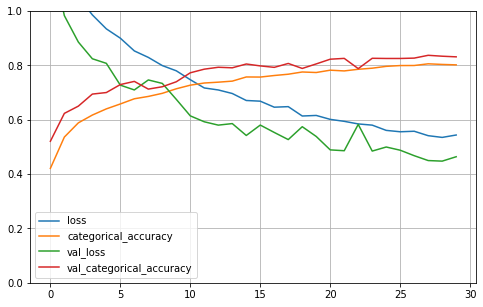

In [28]:
#Gráfica de linea de aprendizaje 
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show(); 

Como podemos observar el acurracy del set de validación logró mejorar llegando al 82%, y la perdida tuvo un mejor comportamiento que en los modelos previos. Algo un tanto curioso de esta línea de aprendizaje es que la exactitud del conjunto de validación obtuvo un puntaje más alto que el de entrenamiento. 

1/1 [==============================] - 0s 16ms/step


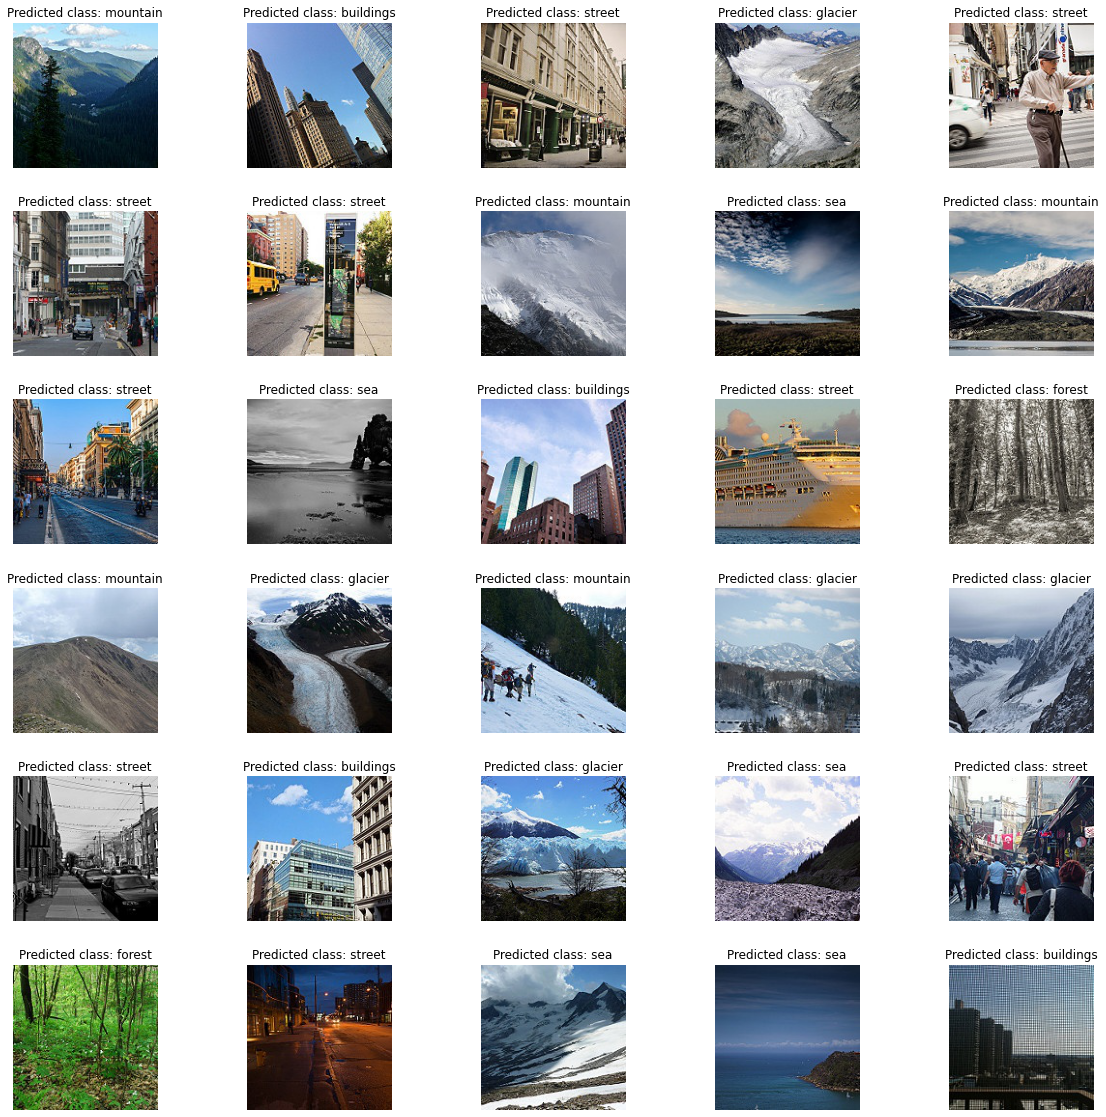

In [34]:
# 30 predicciones del conjunto de imagenes de predicción
plt.figure(figsize = (20 , 20))
for i in range(30):
    plt.subplot(6 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    image_path = prediction_dir + random.choice(os.listdir(prediction_dir))
    prediction = classify(image_path,model)
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted class: {prediction}')
    plt.axis("off")

Finalmente en este conjunto de predicciones podemos ver que obtuvo 29/30 correctas, con tan solo 1 error en imagenes, aunque es comprensible la confusión ya que una de las imagenes es de "sea" pero mayoritariamente se ve un crucero. 
En estricto sentido otra de las imagenes clasificada como mountain, podría ser glacier, pero considero es mejor dejarla a desición del expectador ya que a pesar de que tiene nieve tiene muchos árboles siendo más parecida a la clasificación predicha. 

Aunque se equivoca en casi la misma cantidad que el modelo previo, es claro que ha logrado clasificar con mayor claridad las clases equivocandose en una con mucho "ruido" (entiendase el crucero, también desconozco la cantidad de imagenes de entrenamiento en "sea" que cuenten con un crucero)

A mi parecer este es un resultado favorable considerando las dimensiones del set de datos y que hay imagenes que no necesariamente retratan su categoría como 'sea' que tiene algunas imágenes de gaviotas y en edificios hay algunas que incluyen parte de calles e inversamente.